In [7]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from sklearn import datasets

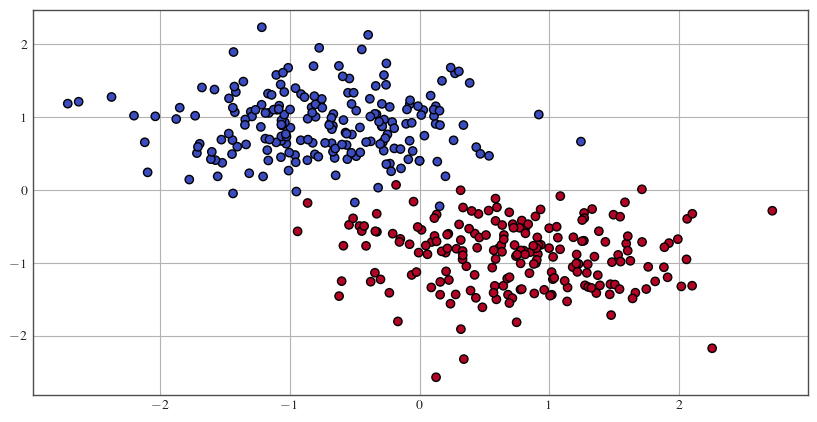

In [8]:
X, y = datasets.make_moons(200, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X, y = datasets.make_blobs([200 for _ in range(2)], random_state=12)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = .2, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_features:
            return out, x
        return out

    @torch.inference_mode()
    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _, indices in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

In [10]:
def dataset_to_xy(dataset):
    X, y = [], []
    for batch in dataset:
        X.append(batch[0])
        y.append(batch[1])
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], s=1)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=100)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

## Active Learning Data Module

In [12]:
from dal_toolbox.active_learning.data import ActiveLearningDataModule

al_datamodule = ActiveLearningDataModule(train_ds, train_batch_size=32)
al_datamodule.random_init(2, class_balanced=True)
next(iter(al_datamodule.unlabeled_dataloader()))

[tensor([[ 1.8154e+00, -1.2571e+00],
         [ 8.9226e-01, -3.6448e-01],
         [-5.5312e-01,  1.3324e+00],
         [-8.0338e-01,  1.0023e+00],
         [ 5.8433e-01, -4.2632e-01],
         [ 6.0871e-01, -8.0201e-01],
         [ 1.0648e+00, -6.5702e-01],
         [ 7.4170e-01, -9.0985e-01],
         [ 1.3292e+00, -2.6431e-01],
         [-1.4178e+00,  1.3420e+00],
         [-1.0287e+00,  6.3226e-01],
         [ 7.7786e-01, -1.0091e+00],
         [ 2.8318e-01, -8.0938e-01],
         [-6.6638e-01,  1.0409e+00],
         [-5.0940e-01,  1.3325e+00],
         [-3.4571e-01, -1.1384e+00],
         [-1.8505e+00,  1.1274e+00],
         [-1.0143e+00,  1.6754e+00],
         [-7.6906e-01,  1.1729e+00],
         [-8.6409e-01,  9.7599e-01],
         [-1.0112e+00,  2.6423e-01],
         [ 3.6017e-02,  7.4352e-01],
         [ 1.2429e+00,  6.6221e-01],
         [ 2.1004e+00, -1.3163e+00],
         [ 1.2740e+00, -1.3107e+00],
         [ 4.2481e-01, -6.0040e-01],
         [-8.1909e-01,  1.6980e+00],
 

## Determinstic Uncertainty Sampling

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/co

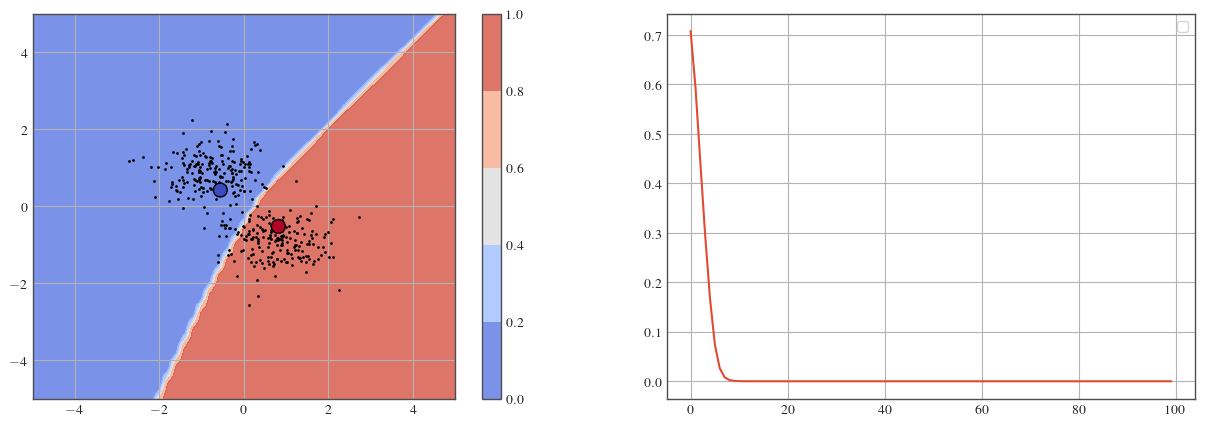

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


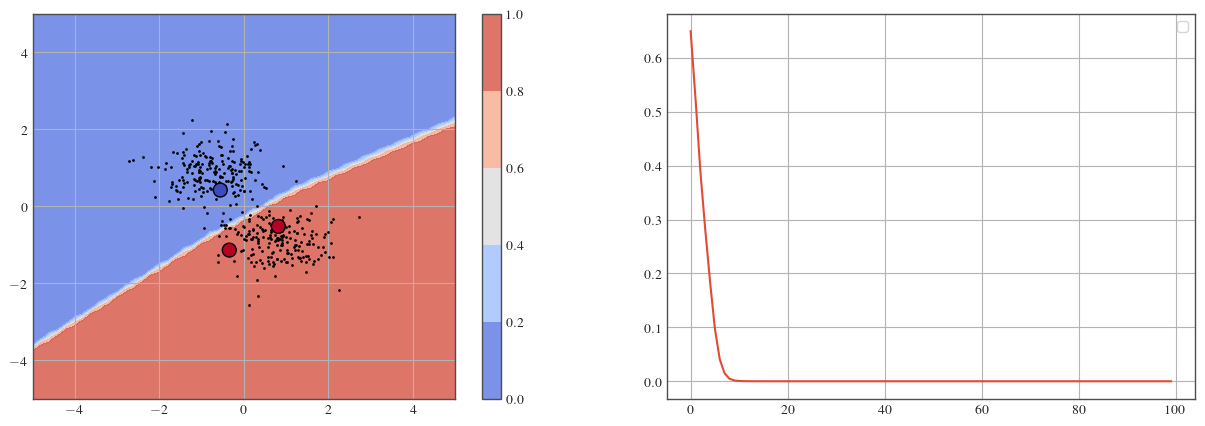

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


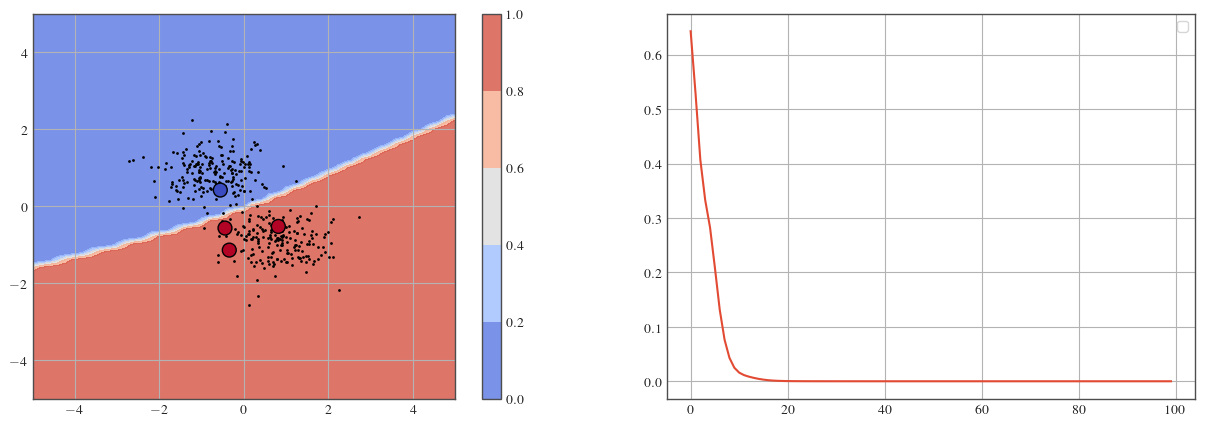

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


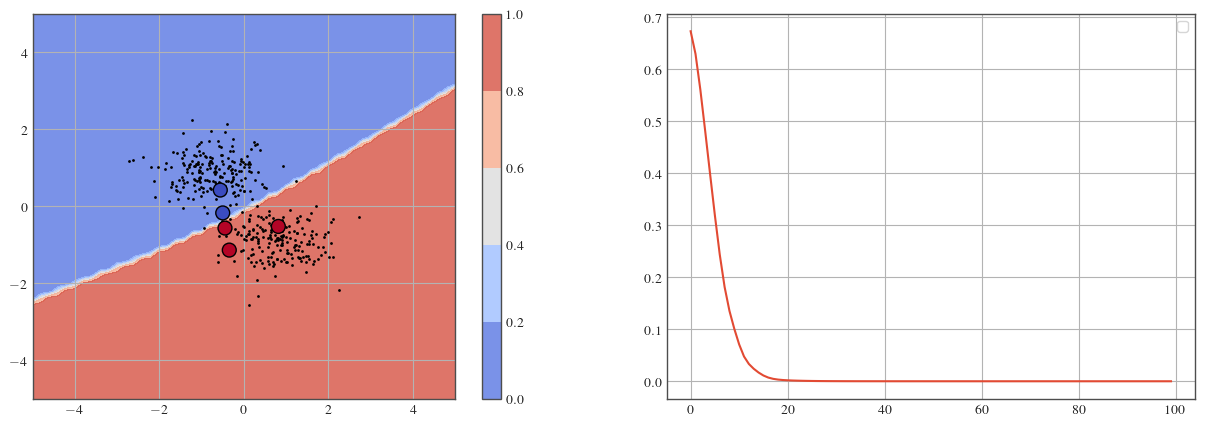

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


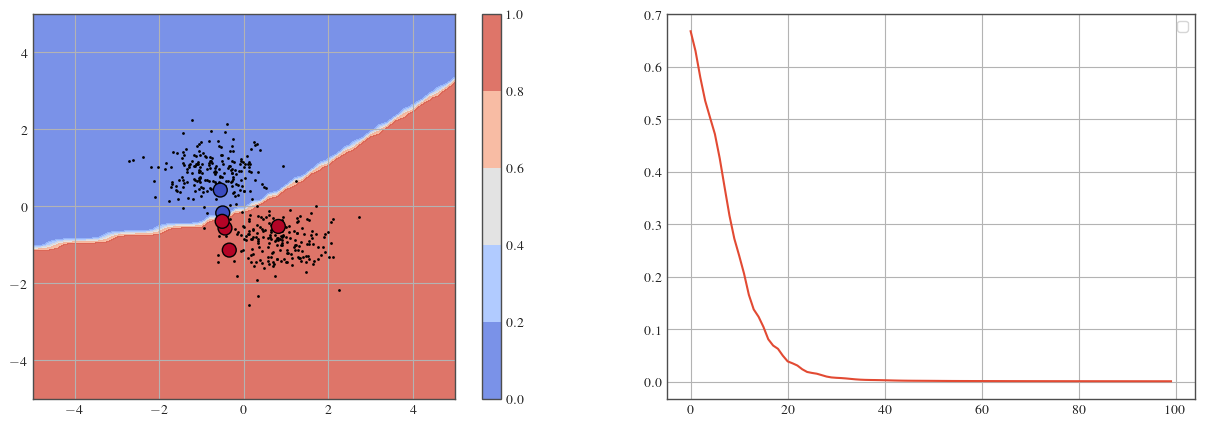

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


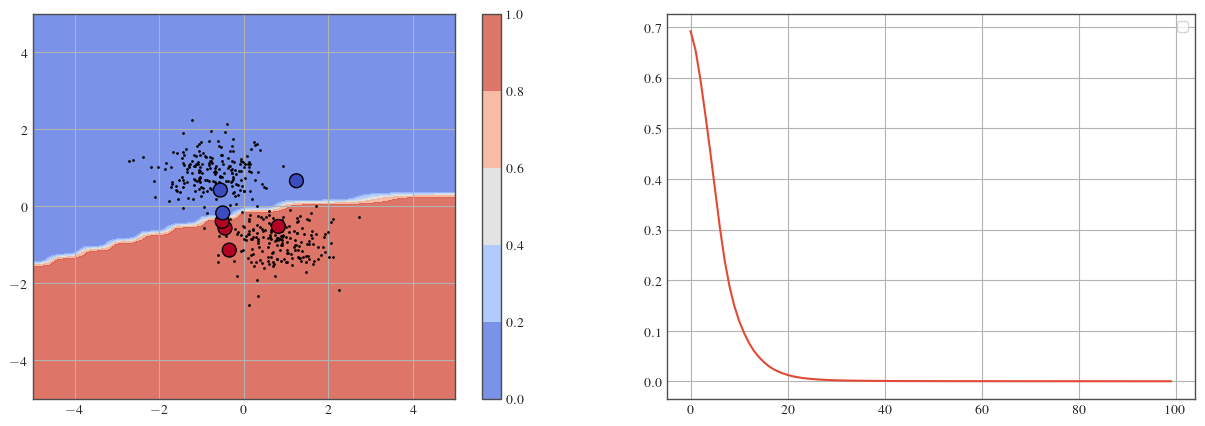

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


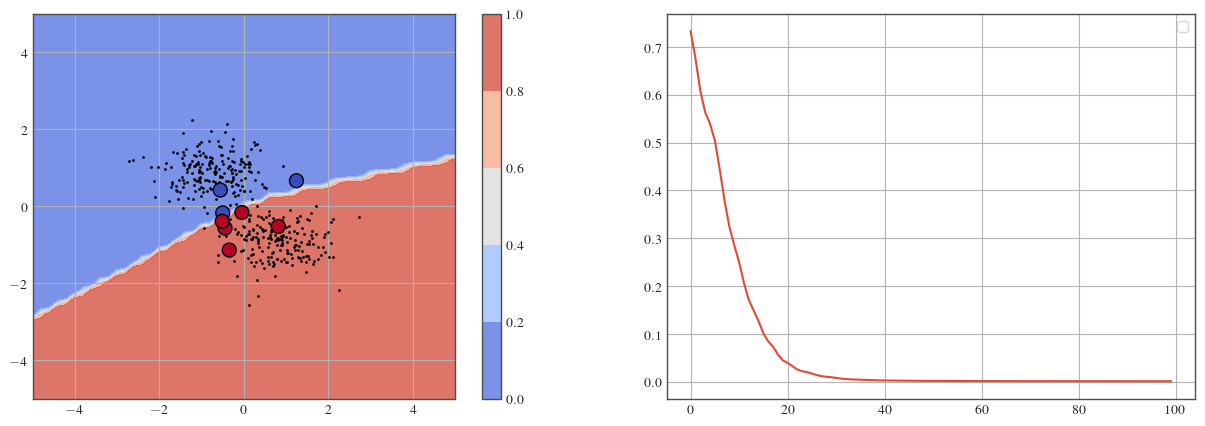

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


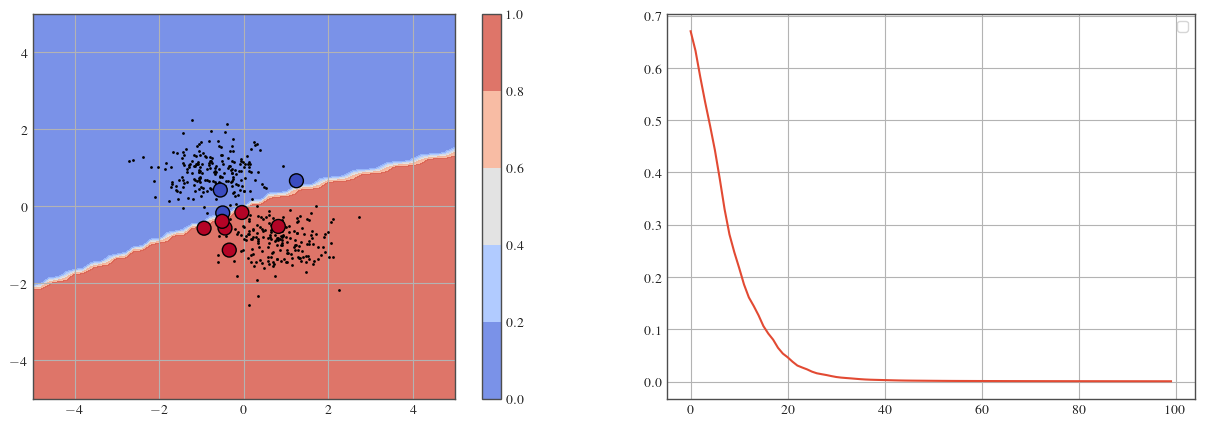

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


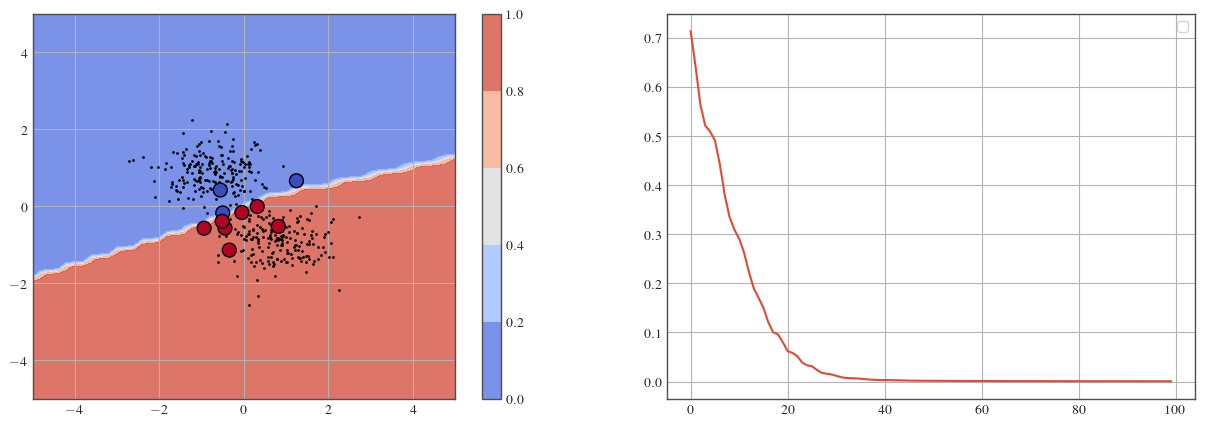

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


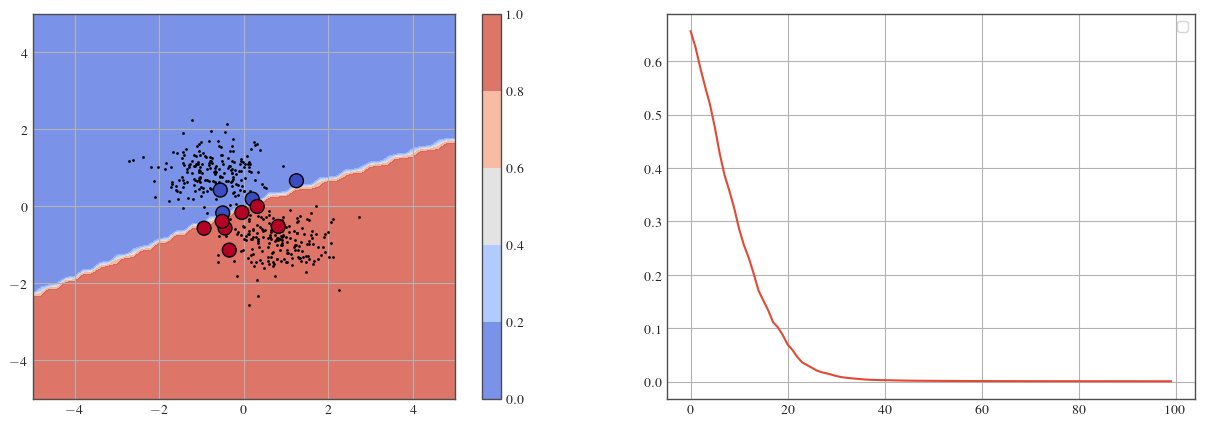

In [13]:
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.utils.callbacks import MetricHistory
from dal_toolbox.active_learning.strategies import EntropySampling, LeastConfidentSampling, MarginSampling

# Train args
np.random.seed(0)
torch.manual_seed(0)
dropout_rate = 0.0
epochs = 100
n_cycles = 10

# AL Setup
al_datamodule = ActiveLearningDataModule(train_ds, train_batch_size=32)
al_datamodule.random_init(2, class_balanced=True)
# al_strat = EntropySampling()
# al_strat = LeastConfidentSampling()
al_strat = MarginSampling()

    
for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = al_strat.query(model, al_datamodule, acq_size=1)
        al_datamodule.update_annotations(indices)
    
    history = MetricHistory()
    model = Net(dropout_rate=dropout_rate, num_classes=2)
    model = DeterministicModel(model, optimizer=torch.optim.SGD, optimizer_params=dict(lr=1e-1, momentum=.9))
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_progress_bar=False)

    trainer.fit(model, al_datamodule)


    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'train_loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_dataset, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()

## Uncertainty Sampling with SNGP

In [20]:
from dal_toolbox.models.utils.random_features import RandomFeatureGaussianProcess
from dal_toolbox.models.utils.spectral_normalization import spectral_norm_linear

class Model(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = dict(norm_bound=.9, n_power_iterations=1),
                 gp_params: dict = dict(num_inducing=1024, kernel_scale=0.05, random_feature_type='orf', scale_random_features=False),
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(
            in_features=feature_dim,
            out_features=num_classes,
            **gp_params,
        )
        self.act = nn.ReLU()
    
    def forward(self, x, mean_field=False, return_cov=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if not self.training:
            out = self.last.forward_mean_field(x)
        else:
            out = self.last(x, return_cov=return_cov)

        return out
    
    @torch.inference_mode()
    def get_logits(self, dataloader, device):
        self.eval()
        self.to(device)
        all_logits = []
        for batch in dataloader:
            samples = batch[0]
            logits = self(samples.to(device), mean_field=True)
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 96.86it/s, v_num=232, train_loss=3.31e-5]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 49.09it/s, v_num=232, train_loss=3.31e-5]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


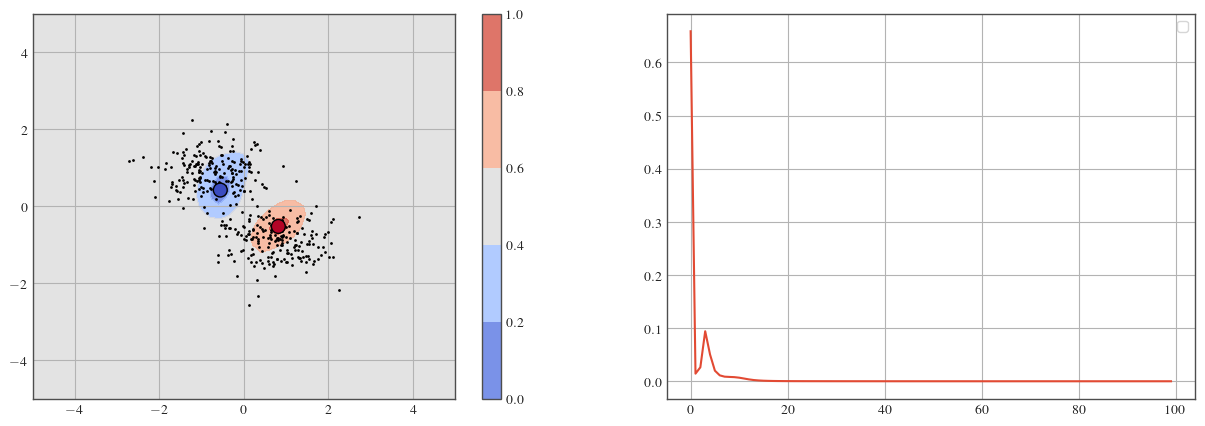

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 88.99it/s, v_num=233, train_loss=6.36e-5]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.35it/s, v_num=233, train_loss=6.36e-5]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


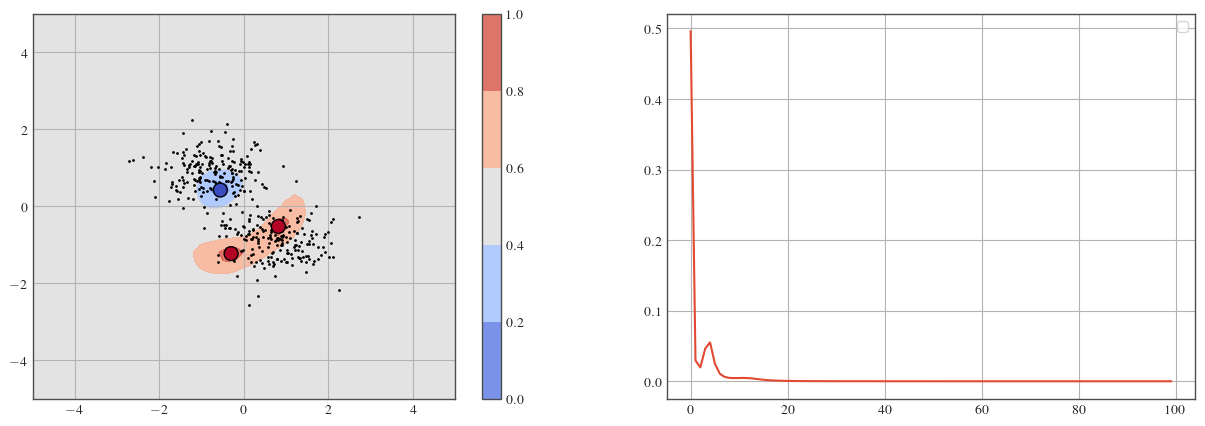

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 104.33it/s, v_num=234, train_loss=6.53e-5] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 54.84it/s, v_num=234, train_loss=6.53e-5] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


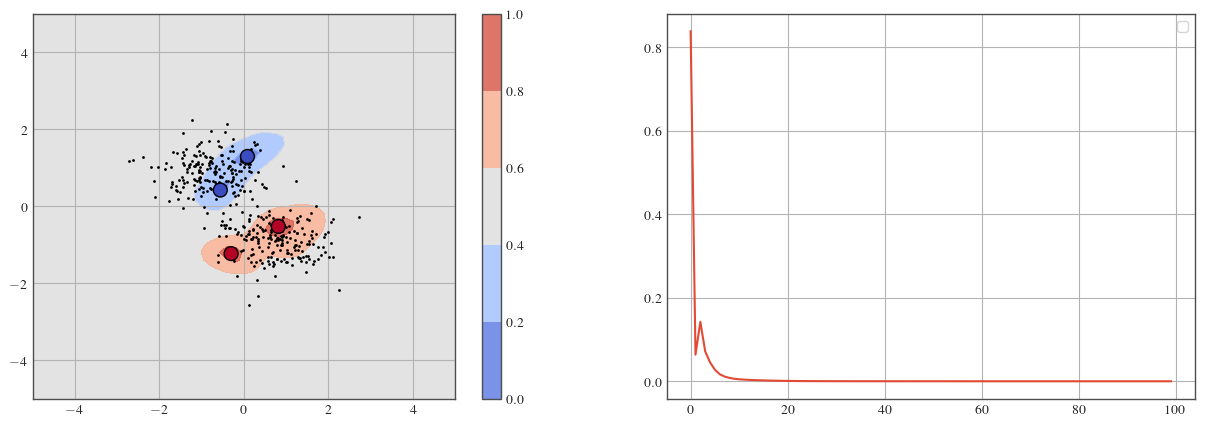

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.11it/s, v_num=235, train_loss=9.6e-5]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 49.42it/s, v_num=235, train_loss=9.6e-5] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


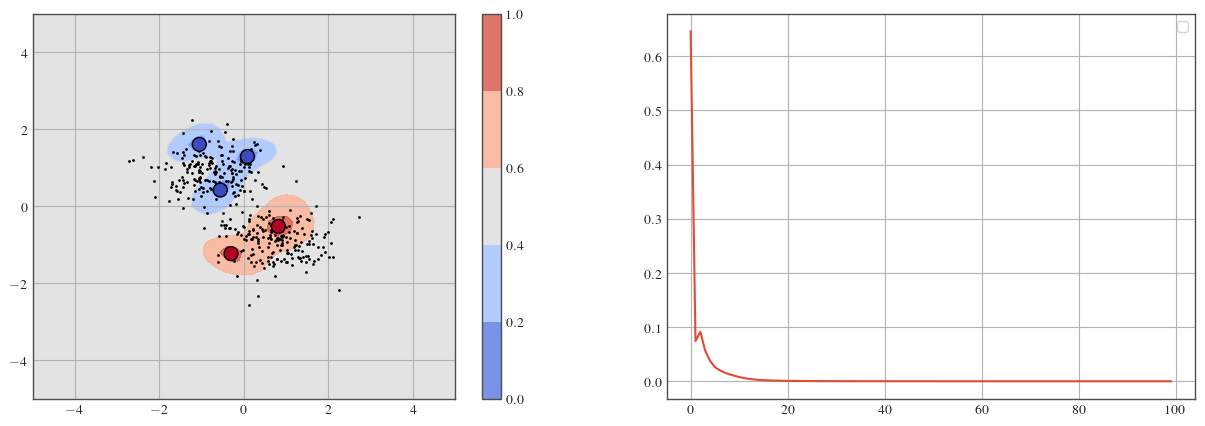

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 100.29it/s, v_num=236, train_loss=9.14e-5] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.41it/s, v_num=236, train_loss=9.14e-5] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


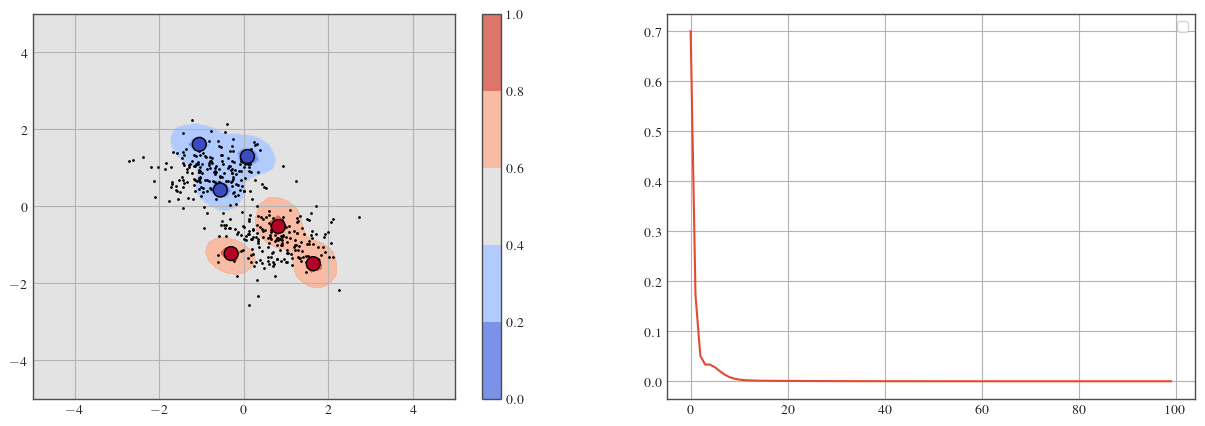

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 101.47it/s, v_num=237, train_loss=0.000126]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.81it/s, v_num=237, train_loss=0.000126] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


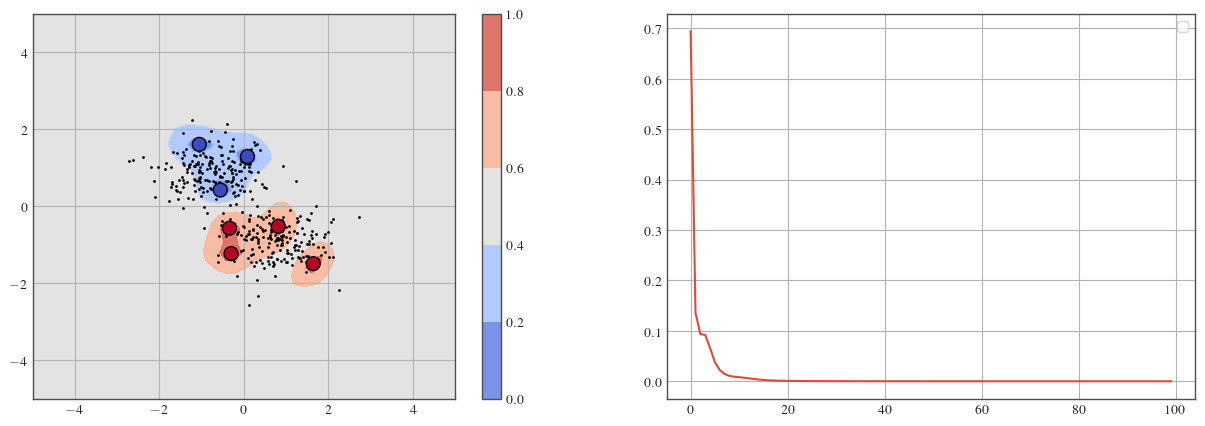

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 96.62it/s, v_num=238, train_loss=0.00015]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.91it/s, v_num=238, train_loss=0.00015]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


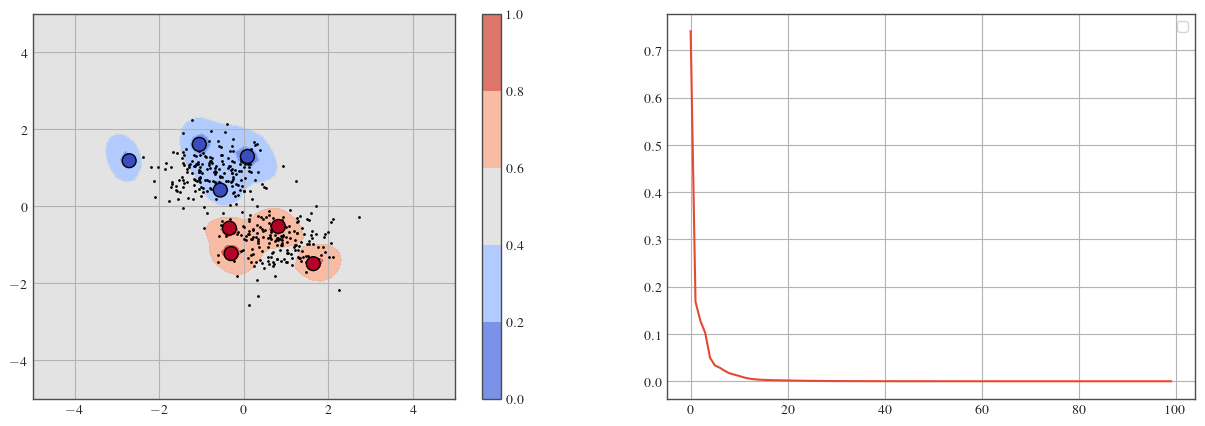

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 120.61it/s, v_num=239, train_loss=0.00018] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 50.17it/s, v_num=239, train_loss=0.00018] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


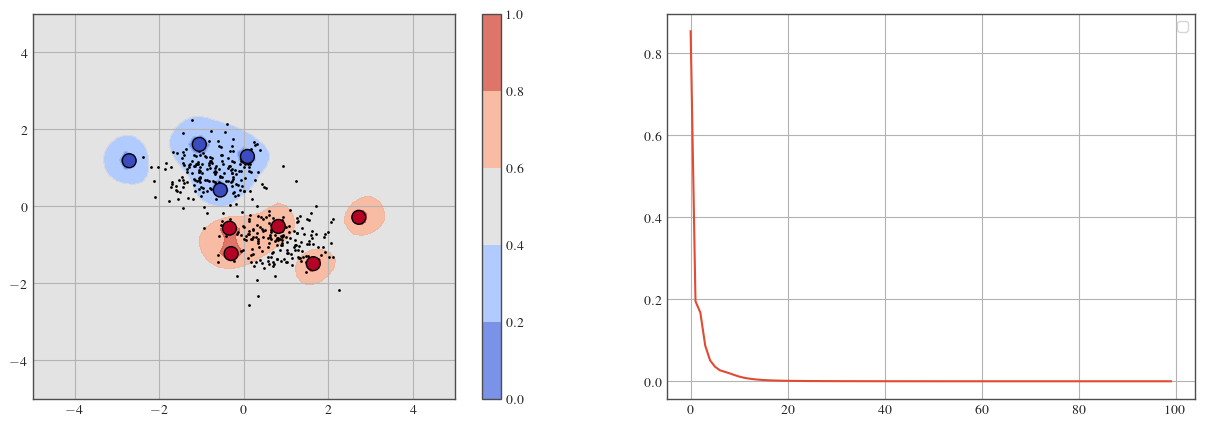

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s, v_num=240, train_loss=0.000176] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 48.05it/s, v_num=240, train_loss=0.000176]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


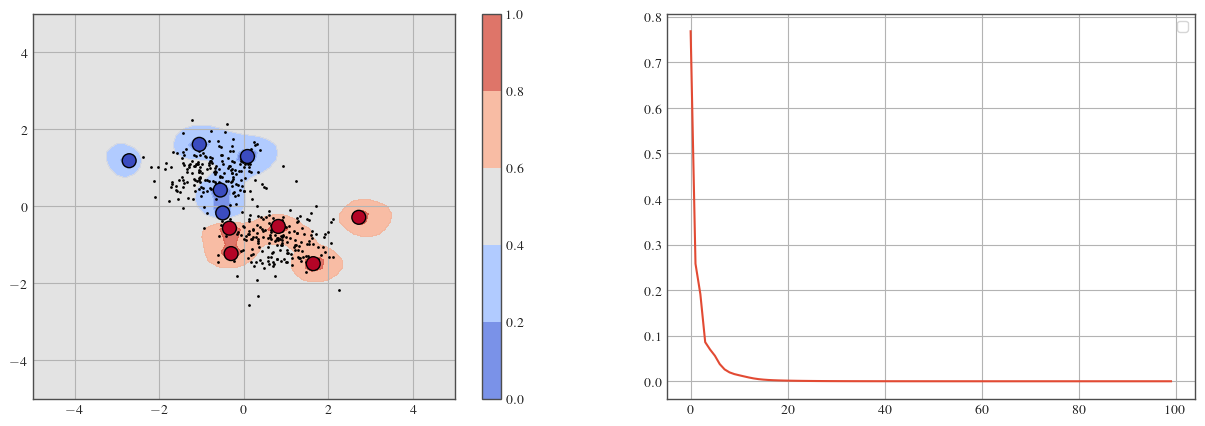

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Model            | 101 K 
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.08it/s, v_num=241, train_loss=0.000221] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 43.89it/s, v_num=241, train_loss=0.000221]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


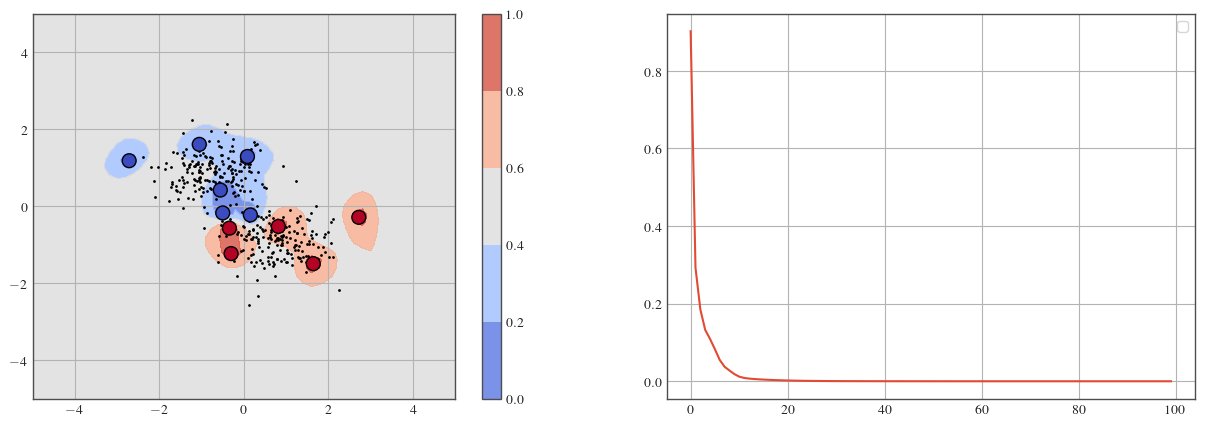

In [21]:
from dal_toolbox.models.sngp import SNGPModel
from dal_toolbox.models.utils.callbacks import MetricHistory
from dal_toolbox.active_learning.strategies import BayesianEntropySampling, BayesianLeastConfidentSampling, BayesianMarginSampling, BALDSampling, VariationRatioSampling

# Train args
np.random.seed(0)
torch.manual_seed(0)
dropout_rate = 0.0
epochs = 100
n_cycles = 10

# AL Setup
al_datamodule = ActiveLearningDataModule(train_ds, train_batch_size=32)
al_datamodule.random_init(2, class_balanced=True)
# al_strat = EntropySampling()
# al_strat = LeastConfidentSampling()
al_strat = MarginSampling()

    
for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = al_strat.query(model, al_datamodule, acq_size=1)
        al_datamodule.update_annotations(indices)
    
    history = MetricHistory()
    model = Model(num_classes=2)
    model = SNGPModel(model)
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_progress_bar=True)
    trainer.fit(model, al_datamodule)


    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'train_loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_dataset, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()